## Review of NDVI workflow

Below we will review the workflow to calculate a difference NDVI from two dates (e.g. pre and post fire event).  

In [13]:
# Import necessary packages
import os
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
from shapely.geometry import box
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.mask import mask
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import earthpy.clip as cl

from shapely.geometry import Point
from shapely.geometry import box



# Ignore warning about missing/empty geometries
import warnings
warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)

# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")

# Set working dir & get data
data = et.data.get_data('spatial-vector-lidar')
# os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))

# Get data and set working directory

os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))
os.getcwd()

'C:\\Users\\bina_\\earth-analytics'

In [14]:
# Import all of your data at the top of your notebook to keep things organized.
country_boundary_us_path = os.path.join("data", "spatial-vector-lidar", 
                                        "usa", "usa-boundary-dissolved.shp")
country_boundary_us = gpd.read_file(country_boundary_us_path)
country_boundary_us

,NAME,geometry
0,United States,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."


In [15]:
state_boundary_us_path = os.path.join("data", "spatial-vector-lidar", 
                                      "usa", "usa-states-census-2014.shp")
state_boundary_us = gpd.read_file(state_boundary_us_path)
state_boundary_us.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


In [16]:
pop_places_path = os.path.join("data", "spatial-vector-lidar", "global", 
                               "ne_110m_populated_places_simple", "ne_110m_populated_places_simple.shp")
pop_places = gpd.read_file(pop_places_path)
pop_places.head()


,scalerank,natscale,labelrank,featurecla,name,namepar,namealt,diffascii,nameascii,adm0cap,...,pop_other,rank_max,rank_min,geonameid,meganame,ls_name,ls_match,checkme,min_zoom,geometry
0,8,10,3,Admin-0 capital,Vatican City,None,None,0,Vatican City,1.0,...,562430,2,2,6691831.0,None,Vatican City,1,0,7.0,POINT (12.45339 41.90328)
1,7,20,0,Admin-0 capital,San Marino,None,None,0,San Marino,1.0,...,0,7,7,3168070.0,None,San Marino,1,5,6.1,POINT (12.44177 43.93610)
2,7,20,0,Admin-0 capital,Vaduz,None,None,0,Vaduz,1.0,...,33009,7,5,3042030.0,None,Vaduz,1,0,6.7,POINT (9.51667 47.13372)
3,6,30,8,Admin-0 capital alt,Lobamba,None,None,0,Lobamba,0.0,...,0,5,4,935048.0,None,Lobamba,1,5,6.0,POINT (31.20000 -26.46667)
4,6,30,8,Admin-0 capital,Luxembourg,None,None,0,Luxembourg,1.0,...,106219,9,8,2960316.0,None,Luxembourg,1,0,6.0,POINT (6.13000 49.61166)


In [17]:
# Are the data all in the same crs?
print("country_boundary_us", country_boundary_us.crs)
print("state_boundary_us", state_boundary_us.crs)
print("pop_places", pop_places.crs)

country_boundary_us {'init': 'epsg:4326'}
state_boundary_us {'init': 'epsg:4326'}
pop_places {'init': 'epsg:4326'}


In [18]:
# Clip the data using GeoPandas clip
points_clip = gpd.clip(pop_places, country_boundary_us)

# View the first 6 rows and a few select columns
points_clip[['name', 'geometry', 'scalerank', 'natscale', ]].head()

AttributeError: module 'geopandas' has no attribute 'clip'

NameError: name 'points_clip' is not defined

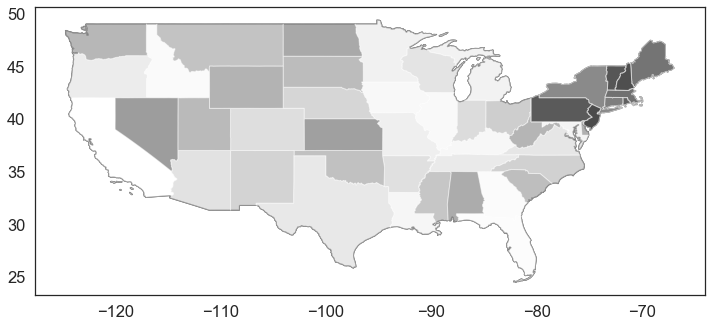

In [9]:
# Plot the data
fig, ax = plt.subplots(figsize=(12, 8))

country_boundary_us.plot(alpha=1,
                         color="white",
                         edgecolor="black",
                         ax=ax)

state_boundary_us.plot(cmap='Greys',
                       ax=ax,
                       alpha=.5)

points_clip.plot(ax=ax,
                 column='name')
ax.set_axis_off()
plt.axis('equal')

# Label each point - note this is just shown here optionally but is not required for your homework
points_clip.apply(lambda x: ax.annotate(s=x['name'],
                                        xy=x.geometry.coords[0],
                                        xytext=(6, 6), textcoords="offset points",
                                        backgroundcolor="white"),
                  axis=1)
plt.show()

In [2]:
# Open fire boundary
ca_fire_bound_path = os.path.join("earthpy-downloads", "frap_fires", "frap_fires.shp")

# To check if path is created
os.path.exists(ca_fire_bound_path)

ca_fire_bound = gpd.read_file(ca_fire_bound_path)
ca_fire_bound.head()

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,geometry
0,1,2007,CA,CCO,LAC,OCTOBER,00246393,2007-10-21,2007-10-23,14,None,0.0,25.7367,8,1,00233414,1902.439051,1.041528e+05,"POLYGON ((138036.906 -402646.363, 138086.986 -..."
1,2,2007,CA,CCO,LAC,MAGIC,00233077,2007-10-22,2007-10-25,14,None,0.0,2824.8800,8,1,00233077,20407.965662,1.143187e+07,"POLYGON ((130072.487 -398622.842, 130094.237 -..."
2,3,2007,CA,USF,ANF,RANCH,00000166,2007-10-20,2007-11-15,2,None,54716.0,58410.3000,7,1,00000166,169150.715690,2.363782e+08,"POLYGON ((114013.974 -379231.746, 114190.835 -..."
3,4,2007,CA,CCO,LAC,EMMA,00201384,2007-09-11,2007-09-11,14,None,0.0,172.2150,8,1,00201384,6117.777086,6.969292e+05,"POLYGON ((176902.236 -388673.082, 176907.996 -..."
4,5,2007,CA,CCO,LAC,CORRAL,00259483,2007-11-24,2007-11-27,14,None,0.0,4708.0000,8,1,00259483,22907.182174,1.905259e+07,"POLYGON ((115905.006 -436381.137, 115926.897 -..."


In [3]:
# ca_fire_bound.info()

In [4]:
# ca_fire_bound.describe()

In [29]:
ca_2014_fires = ca_fire_bound[ca_fire_bound["YEAR_"]=='2014']
# ca_2014_fires.set_index('GIS_ACRES', inplace = True)
# ca_2014_fires.to_csv('ca_2014_firesb.csv')
ca_2014_fires.head(3)


,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,geometry
12702,12703,2014,CA,USF,BDF,ETIWANDA,00006646,2014-04-30,None,9,None,2190.0,2141.8400,1,1,None,22002.159236,8.667722e+06,"POLYGON ((225728.402 -422124.230, 225728.640 -..."
17750,17751,2014,CA,CDF,AEU,SAND,018237,2014-07-26,2014-07-30,10,None,4240.0,4239.2700,1,1,None,29457.419842,1.715572e+07,"POLYGON ((-69289.771 60861.423, -69317.606 608..."
17751,17752,2014,CA,CDF,BDU,KEOUGH,010406,2014-08-09,2014-08-20,14,None,17.0,18.1595,1,1,None,1565.639280,7.348884e+04,"POLYGON ((145458.621 -83727.318, 145657.588 -8..."


In [40]:
sd6_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"]=='COMBAT-BASILONE COMPLEX']
sd6_2014_fires

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,geometry
17877,17878,2014,CA,DOD,MCP,COMBAT-BASILONE COMPLEX,001363,2014-05-19,None,0,Basilone Complex,0.0,1457.19,8,1,None,13508.03627,5.897019e+06,"POLYGON ((229725.623 -508236.865, 229718.911 -..."


In [48]:
sd1_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"]=='COCOS']
sd2_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"]=='BERNARDO']
sd3_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"]=='POINSETTIA']
sd4_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"]=='PULGAS-BASILONE COMPLEX']
sd5_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"]=='TOMAHAWK-BASILONE COMPLEX']
sd6_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"]=='COMBAT-BASILONE COMPLEX']
sd3_2014_fires

# sd_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"]==('COCOS','POINSETTIA', 'BERNARDO')]
# ca_2014_fires.filter(regex='(?=.*COCOS)(?=.*BERNARDO)')
# ca_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"].str.contains('COCOS', 'BERNARDO')]


# sd_2014_fires.filter(regex='(?=.*BASILONE COMPLEX)(?=.*BERNARDO)')
# sd_2014_fires = ca_2014_fires[ca_2014_fires["GIS_ACRES"]<2000]
# sd1_2014_fires

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,geometry
17905,17906,2014,CA,LRA,MVU,POINSETTIA,010165,2014-05-14,2014-05-18,14,<Null>,600.0,376.94,1,1,None,15678.610991,1.525423e+06,"POLYGON ((253628.610 -540400.486, 253610.819 -..."


In [7]:
selected_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"].isin(['COCOS', 
                                                                'BERNARDO', 
                                                                'POINSETTIA',
                                                               'PULGAS-BASILONE COMPLEX',
                                                               'TOMAHAWK-BASILONE COMPLEX'])]
selected_fires

# selected_fires.to_file("selected.shp")


,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,geometry
17876,17877,2014,CA,DOD,MCP,PULGAS-BASILONE COMPLEX,001363,2014-05-19,None,0,Basilone Complex,0.0,15186.10,8,1,None,56943.425801,6.145614e+07,"POLYGON ((238332.127 -519987.204, 238314.507 -..."
17883,17884,2014,CA,LRA,MVU,COCOS,010212,2014-05-14,2014-05-23,14,<Null>,2000.0,1994.79,1,1,None,30297.925298,8.072617e+06,"MULTIPOLYGON (((268503.552 -540755.537, 268513..."
17904,17905,2014,CA,LRA,MVU,BERNARDO,010055,2014-05-13,2014-05-18,2,<Null>,1548.0,1331.43,1,1,None,23687.643963,5.388089e+06,"POLYGON ((265317.914 -552814.323, 265302.353 -..."
17905,17906,2014,CA,LRA,MVU,POINSETTIA,010165,2014-05-14,2014-05-18,14,<Null>,600.0,376.94,1,1,None,15678.610991,1.525423e+06,"POLYGON ((253628.610 -540400.486, 253610.819 -..."


In [49]:
sd5_2014_fires = ca_2014_fires[ca_2014_fires["FIRE_NAME"]=='TOMAHAWK- BASILONE COMPLEX']
sd5_2014_fires

,OBJECTID,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,COMMENTS,REPORT_AC,GIS_ACRES,C_METHOD,OBJECTIVE,FIRE_NUM,Shape_Leng,Shape_Area,geometry
17875,17876,2014,CA,DOD,MCP,TOMAHAWK- BASILONE COMPLEX,001363,2014-05-19,None,0,Basilone Complex,0.0,5365.31,8,1,None,34819.442071,2.171264e+07,"MULTIPOLYGON (((255468.962 -516099.671, 255450..."


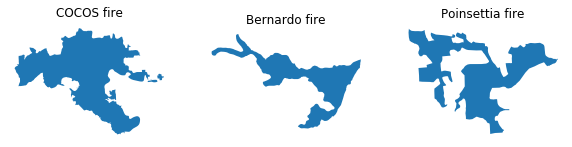

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 12))

# Set a larger tolerance yields a blockier polygon
sd1_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax1)

# Set  a larger tolerance yields a blockier polygon
sd2_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax2)
sd3_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax3)
# sd4_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax4)
# sd5_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax5)


ax1.set_title(
    "COCOS fire")
ax2.set_title(
    "Bernardo fire")
ax3.set_title(
    "Poinsettia fire")
# ax4.set_title(
#     "Pulgas fire")
# ax5.set_title(
#     "Tomahawk fire")

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
# ax4.set_axis_off()
# ax5.set_axis_off()
plt.show()
# plt.savefig('BCP_fire_boundary.png')

In [79]:
# os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data','output_figures', "sandiego_2014_fires"))
plt.savefig('data/output_figures/sandiego_2014_fires/BCP2_fire_boundary.png')

FileNotFoundError: [Errno 2] No such file or directory: 'data/output_figures/sandiego_2014_fires/BCP2_fire_boundary.png'

<Figure size 432x288 with 0 Axes>

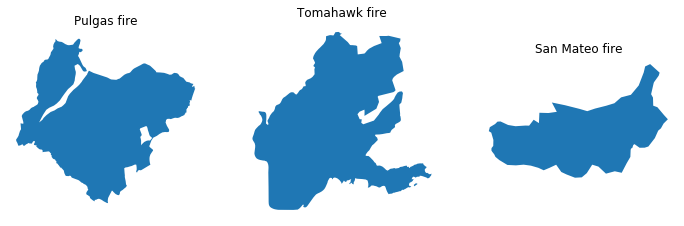

In [56]:
fig, (ax1, ax2, ax3,) = plt.subplots(1,3, figsize=(12, 16))

# Set a larger tolerance yields a blockier polygon
# sd1_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax1)
sd4_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax1)
# sd3_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax3)
# Set  a larger tolerance yields a blockier polygon
# sd4_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax2)

sd5_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax2)


sd6_2014_fires.simplify(2, preserve_topology=True).plot(ax=ax3)


# ax1.set_title(
#     "COCOS fire")
ax1.set_title(
    "Pulgas fire")
# ax3.set_title(
#     "Poinsettia fire")
# ax4.set_title(
#     "Bernardo fire")
ax2.set_title(
    "Tomahawk fire")
ax3.set_title(
    "San Mateo fire")

ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
# ax4.set_axis_off()
# ax5.set_axis_off()
# ax6.set_axis_off()

plt.show()

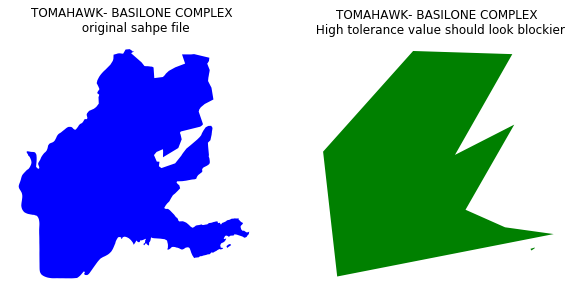

In [58]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

# Set a larger tolerance yields a blockier polygon
sd5_2014_fires.plot(ax=ax1, color= 'blue')

# Set  a larger tolerance yields a blockier polygon
sd5_2014_fires.simplify(1000, preserve_topology=True).plot(ax=ax2, color = 'g')

ax1.set_title(
    "TOMAHAWK- BASILONE COMPLEX \n original sahpe file")
ax2.set_title(
    "TOMAHAWK- BASILONE COMPLEX \n High tolerance value should look blockier")
ax1.set_axis_off()
ax2.set_axis_off()
plt.show()

'C:\\Users\\bina_\\earth-analytics\\data\\output_sd_fires'

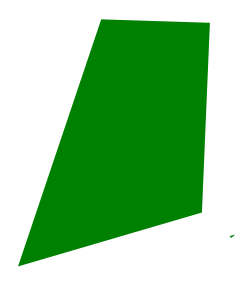

In [12]:
fig, (ax) = plt.subplots(figsize=(5, 5))

# Set  a larger tolerance yields a blockier polygon
sd5_2014_fires.simplify(10000, preserve_topology=True).plot(ax=ax, color = 'g')

ax.set_axis_off()



# # Creat new directory/ folder  
# directory = "output_sd_fires"
    
# # Parent Directory path  
# parent_dir = "C:\\Users\\bina_\\earth-analytics\\data"

# # Path  
# path = os.path.join(parent_dir, directory)
# os.makedirs(path)
# os.chdir("output_sd_fires")
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data','output_sd_fires'))
os.getcwd()
# # # # save_file = os.path.join(your_directory, your_file_name)
# # # plt.savefig('tomahawk2014.png')
# path = os.path.join('output2_sd_fires', "tomahawk2014", "bernardo2014")
# os.makedirs(path)
# # save_file = os.path.join('tomahawk2014.shp')
# # os.getcwd()
# plt.show()

In [13]:

# Make a copy of the original geodataframe

tomahawk = sd5_2014_fires.copy()



# Update the geometry of the copy
tomahawk["geometry"] = tomahawk.geometry.simplify(1000, preserve_topology=True)

tomahawk.to_file("tomahawk2014.shp")

In [14]:
from shapely.geometry import box
# Change directory

os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data','output_sd_fires'))

tomahawk = sd5_2014_fires.copy()

tomahawk.total_bounds                                                      

# This creating a bounding box
tomahawk_bdy=box(*tomahawk.total_bounds)

print(box(*tomahawk.total_bounds))  
# tomahawk_gdf = gpd.GeoDataFrame(crs=tomahawk.crs, geometry=[box(*tomahawk.total_bounds)])
tomahawk_gdf = gpd.GeoDataFrame(crs=tomahawk.crs, geometry=[tomahawk_bdy]) 

tomahawk_gdf.to_file("tomahawk2014.shp")

POLYGON ((256064.7452000007 -516958.7390000001, 256064.7452000007 -510592.1687000003, 249659.5826000012 -510592.1687000003, 249659.5826000012 -516958.7390000001, 256064.7452000007 -516958.7390000001))


In [15]:
# fig, ax1 = plt.subplots(figsize=(10, 10))
# tomahawk_gdf.plot(ax=ax1, color= 'g')


In [16]:
cocos = sd1_2014_fires.copy()

cocos.total_bounds                                                      

# This creating a bounding box
cocos_bdy=box(*cocos.total_bounds)

print(box(*cocos.total_bounds))  
cocos_gdf = gpd.GeoDataFrame(crs=cocos.crs, geometry=[cocos_bdy]) 

cocos_gdf.to_file("cocos2014.shp")

POLYGON ((268961.0219999999 -542742.8267999999, 268961.0219999999 -538848.5866, 263495.8161999993 -538848.5866, 263495.8161999993 -542742.8267999999, 268961.0219999999 -542742.8267999999))


In [17]:
# fig, ax1 = plt.subplots(figsize=(10, 10))
# cocos_gdf.plot(ax=ax1, color= 'g')

In [18]:
bernardo = sd2_2014_fires.copy()

bernardo.total_bounds                                                      

# This creating a bounding box
bernardo_bdy=box(*bernardo.total_bounds)

print(box(*bernardo.total_bounds))  
# tomahawk_gdf = gpd.GeoDataFrame(crs=tomahawk.crs, geometry=[box(*tomahawk.total_bounds)])
bernardo_gdf = gpd.GeoDataFrame(crs=bernardo.crs, geometry=[bernardo_bdy]) 

bernardo_gdf.to_file("bernardo2014.shp")

POLYGON ((269077.0249999985 -554981.9990999997, 269077.0249999985 -551039.4484999999, 262840.9626000002 -551039.4484999999, 262840.9626000002 -554981.9990999997, 269077.0249999985 -554981.9990999997))


In [19]:
poinsettia = sd3_2014_fires.copy()

poinsettia.total_bounds                                                      

# This creating a bounding box
poinsettia_bdy=box(*poinsettia.total_bounds)

print(box(*cocos.total_bounds))  
# tomahawk_gdf = gpd.GeoDataFrame(crs=tomahawk.crs, geometry=[box(*tomahawk.total_bounds)])
poinsettia_gdf = gpd.GeoDataFrame(crs=poinsettia.crs, geometry=[poinsettia_bdy]) 

poinsettia_gdf.to_file("poinsettia2014.shp")

POLYGON ((268961.0219999999 -542742.8267999999, 268961.0219999999 -538848.5866, 263495.8161999993 -538848.5866, 263495.8161999993 -542742.8267999999, 268961.0219999999 -542742.8267999999))


In [20]:
pulgas = sd4_2014_fires.copy()

pulgas.total_bounds                                                      

# This creating a bounding box
pulgas_bdy=box(*pulgas.total_bounds)

print(box(*pulgas.total_bounds))  
# tomahawk_gdf = gpd.GeoDataFrame(crs=tomahawk.crs, geometry=[box(*tomahawk.total_bounds)])
pulgas_gdf = gpd.GeoDataFrame(crs=pulgas.crs, geometry=[pulgas_bdy]) 

pulgas_gdf.to_file("pulgas2014.shp")

POLYGON ((248645.5621999986 -523716.4363000002, 248645.5621999986 -513173.5362999998, 237168.8363999985 -513173.5362999998, 237168.8363999985 -523716.4363000002, 248645.5621999986 -523716.4363000002))


In [38]:

os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data','output_sd_fires'))
san_mateo = sd6_2014_fires.copy()

san_mateo.total_bounds                                                      

# This creating a bounding box
san_mateo_bdy=box(*san_mateo.total_bounds)

print(box(*san_mateo.total_bounds))  
# tomahawk_gdf = gpd.GeoDataFrame(crs=tomahawk.crs, geometry=[box(*tomahawk.total_bounds)])
san_mateo_gdf = gpd.GeoDataFrame(crs=san_mateo.crs, geometry=[san_mateo_bdy]) 

san_mateo_gdf.to_file("san_mateo2014.shp")

POLYGON ((230648.191399999 -508923.8930000002, 230648.191399999 -506107.3607999999, 226209.750500001 -506107.3607999999, 226209.750500001 -508923.8930000002, 230648.191399999 -508923.8930000002))
